# Import des librairies + paramètres

In [1]:
import warnings; warnings.simplefilter('ignore')
import P4_toolbox        as p4

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

# to show and store figures in the notebook
%matplotlib inline

# to load datasets
transactions_normalized = pd.read_csv('./dataset/transactions_normalized.csv')
transactions_original = pd.read_csv('./dataset/transactions_original.csv', index_col = 'date', parse_dates = True)
products = pd.read_csv('./dataset/products_preprocessed.csv')
outliers = pd.read_csv('./dataset/outliers.csv', index_col = 'date', parse_dates = True)

# put target feature in first place
transactions_normalized = transactions_normalized[['price', 
                                                   'date', 
                                                   'id_prod', 
                                                   'categ', 
                                                   'id_sale', 
                                                   'id_customer', 
                                                   'is_male', 
                                                   'age' ]]

# pandas settings
pd.set_option('display.max_row', 110)
pd.set_option('display.max_column', 110)

# Encodage
On convertit le dataframe en tableau numpy et on encode les 5 variables qualitatives.

In [2]:
#model selection
from sklearn.preprocessing import OrdinalEncoder

# transform dataframe into numpy array
transactions_array = np.array(transactions_normalized)

# encoder initialization
encoder = OrdinalEncoder()

# transformed matrix
transactions_array[:,1:6] = encoder.fit_transform(transactions_array[:,1:6])
transformed_matrix = transactions_array[:,1:6]

# Normalisation / Standardisation
Normaliser revient à mettre toutes les variables quantitatives sur une même échelle.
La standardisation : moyenne à 0 et écart-type à 1.
Le transformer StandardScaler est une standardisation classique.

In [3]:
# transformer selection
from sklearn.preprocessing import StandardScaler

# transformer initilization
transformer = StandardScaler()

# transformed matrix
transactions_array = transformer.fit_transform(transactions_array)

#visual result
pd.DataFrame(transactions_array, columns=transactions_normalized.columns).describe()

,price,date,id_prod,categ,id_sale,id_customer,is_male,age
count,2.350540e+05,2.350540e+05,2.350540e+05,2.350540e+05,2.350540e+05,2.350540e+05,2.350540e+05,2.350540e+05
mean,-3.395375e-15,-1.188280e-17,7.385328e-16,-2.492738e-14,1.140452e-15,-6.110208e-17,7.779910e-15,-3.681787e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.057400e+00,-1.732043e+00,-1.336999e+00,-7.269621e-01,-1.739177e+00,-1.740039e+00,-9.690807e-01,-2.281401e+00
25%,-5.971235e-01,-8.660217e-01,-8.863030e-01,-7.269621e-01,-8.633594e-01,-8.676378e-01,-9.690807e-01,-6.805919e-01
50%,-2.080140e-01,0.000000e+00,-4.231737e-01,-7.269621e-01,-1.390129e-02,1.517895e-02,-9.690807e-01,1.976205e-02
75%,2.347020e-01,8.660217e-01,1.123181e+00,1.030725e+00,8.654276e-01,8.662540e-01,1.031906e+00,6.200655e-01
max,6.755289e+00,1.732043e+00,1.606514e+00,2.788413e+00,1.717672e+00,1.724769e+00,1.031906e+00,2.220875e+00


# Premier aperçu : heatmap de corrélations linéaires

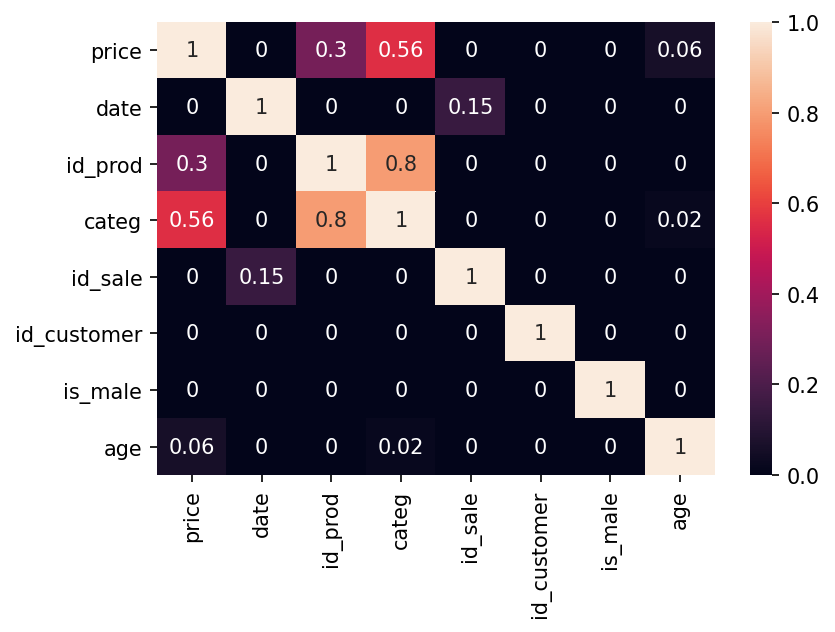

In [4]:
df = pd.DataFrame(transactions_array, columns=transactions_normalized.columns)
plt.figure(dpi=150)
sns.heatmap(((df.corr())**2).round(2), annot=True);

## Conclusions préliminaires : corrélations sur des relations déjà connues
  
1 produit = 1 catégorie . Chaque catégorie a une tranche de prix. Les identifiants de ventes s'incrémentent avec le temps.

### Il n'y a pas de relation linéaire entre les différentes variables.

# Analyse sur la fréquence des ventes par produit

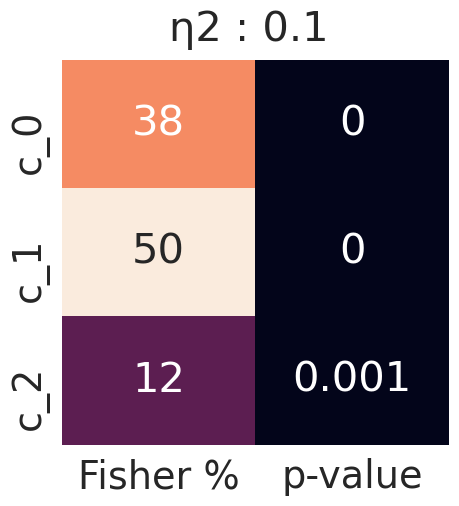

In [5]:
p4.eta2('month_sales_rate', 'categ', products)

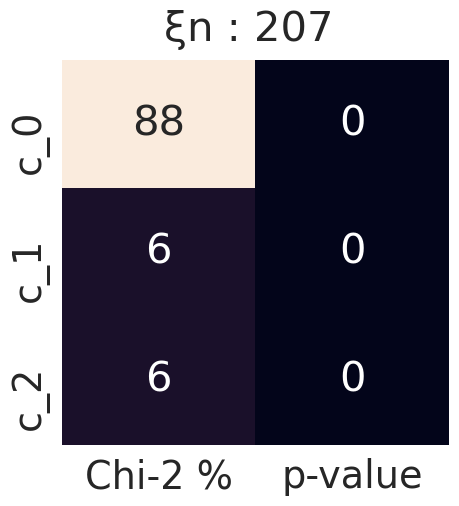

In [6]:
p4.chi2('month_sales_rate', 'categ', products)

# Analyse sur le montant des ventes par produit

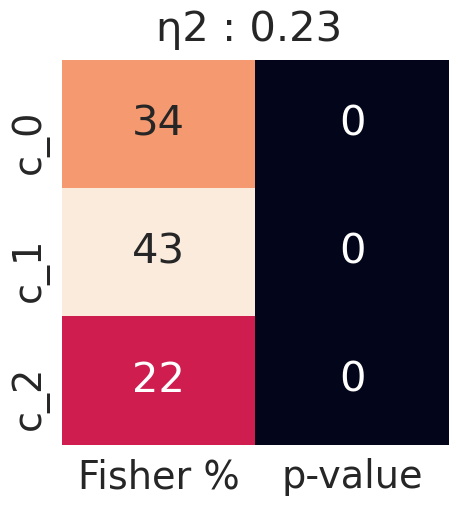

In [7]:
p4.eta2('turnover','categ', products)

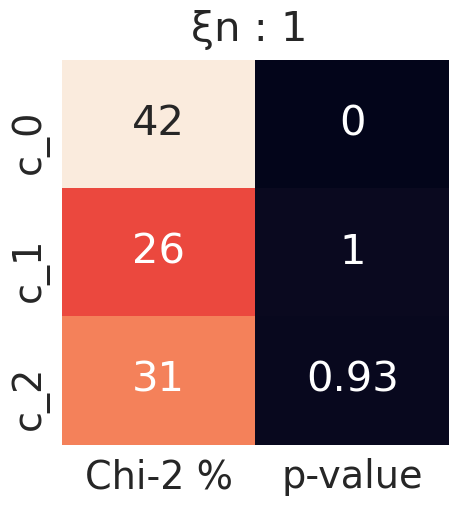

In [8]:
p4.chi2('turnover','categ', products)

# Diagrammes en cammenbert

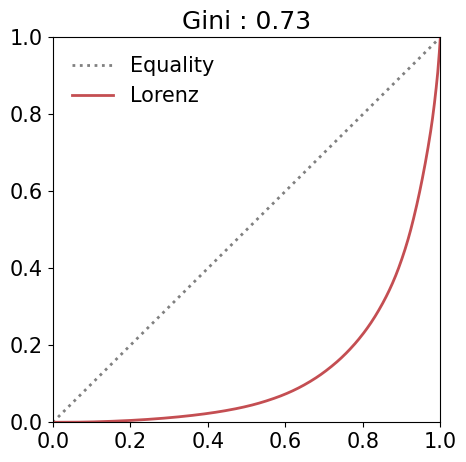

In [9]:
p = transactions_original.groupby(['id_prod','categ']).sum().reset_index()
table = p4.lorenz_gini_graph_dataframe('price', p)

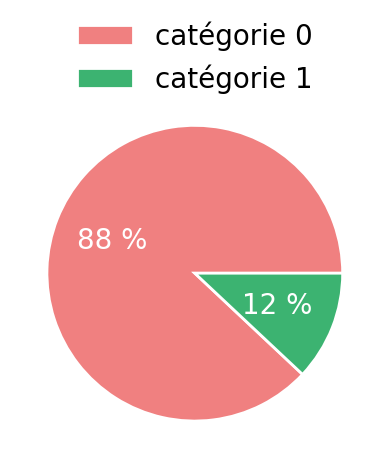

In [10]:
worst_sales = table[table['cum_frequences'] <= 0.80]
p4.pie_chart(worst_sales, p, ['lightcoral', 'mediumseagreen'])

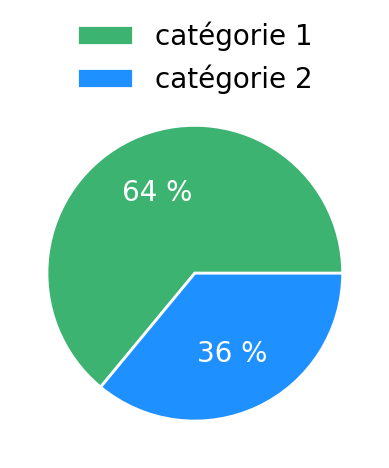

In [11]:
best_sales = table[table['cum_frequences'] >= 0.80]
p4.pie_chart(best_sales, p, ['mediumseagreen', 'dodgerblue'])

# Graphiques
On va ici reprendre les outliers car ici seulement, on peut les inclure dans le lot.

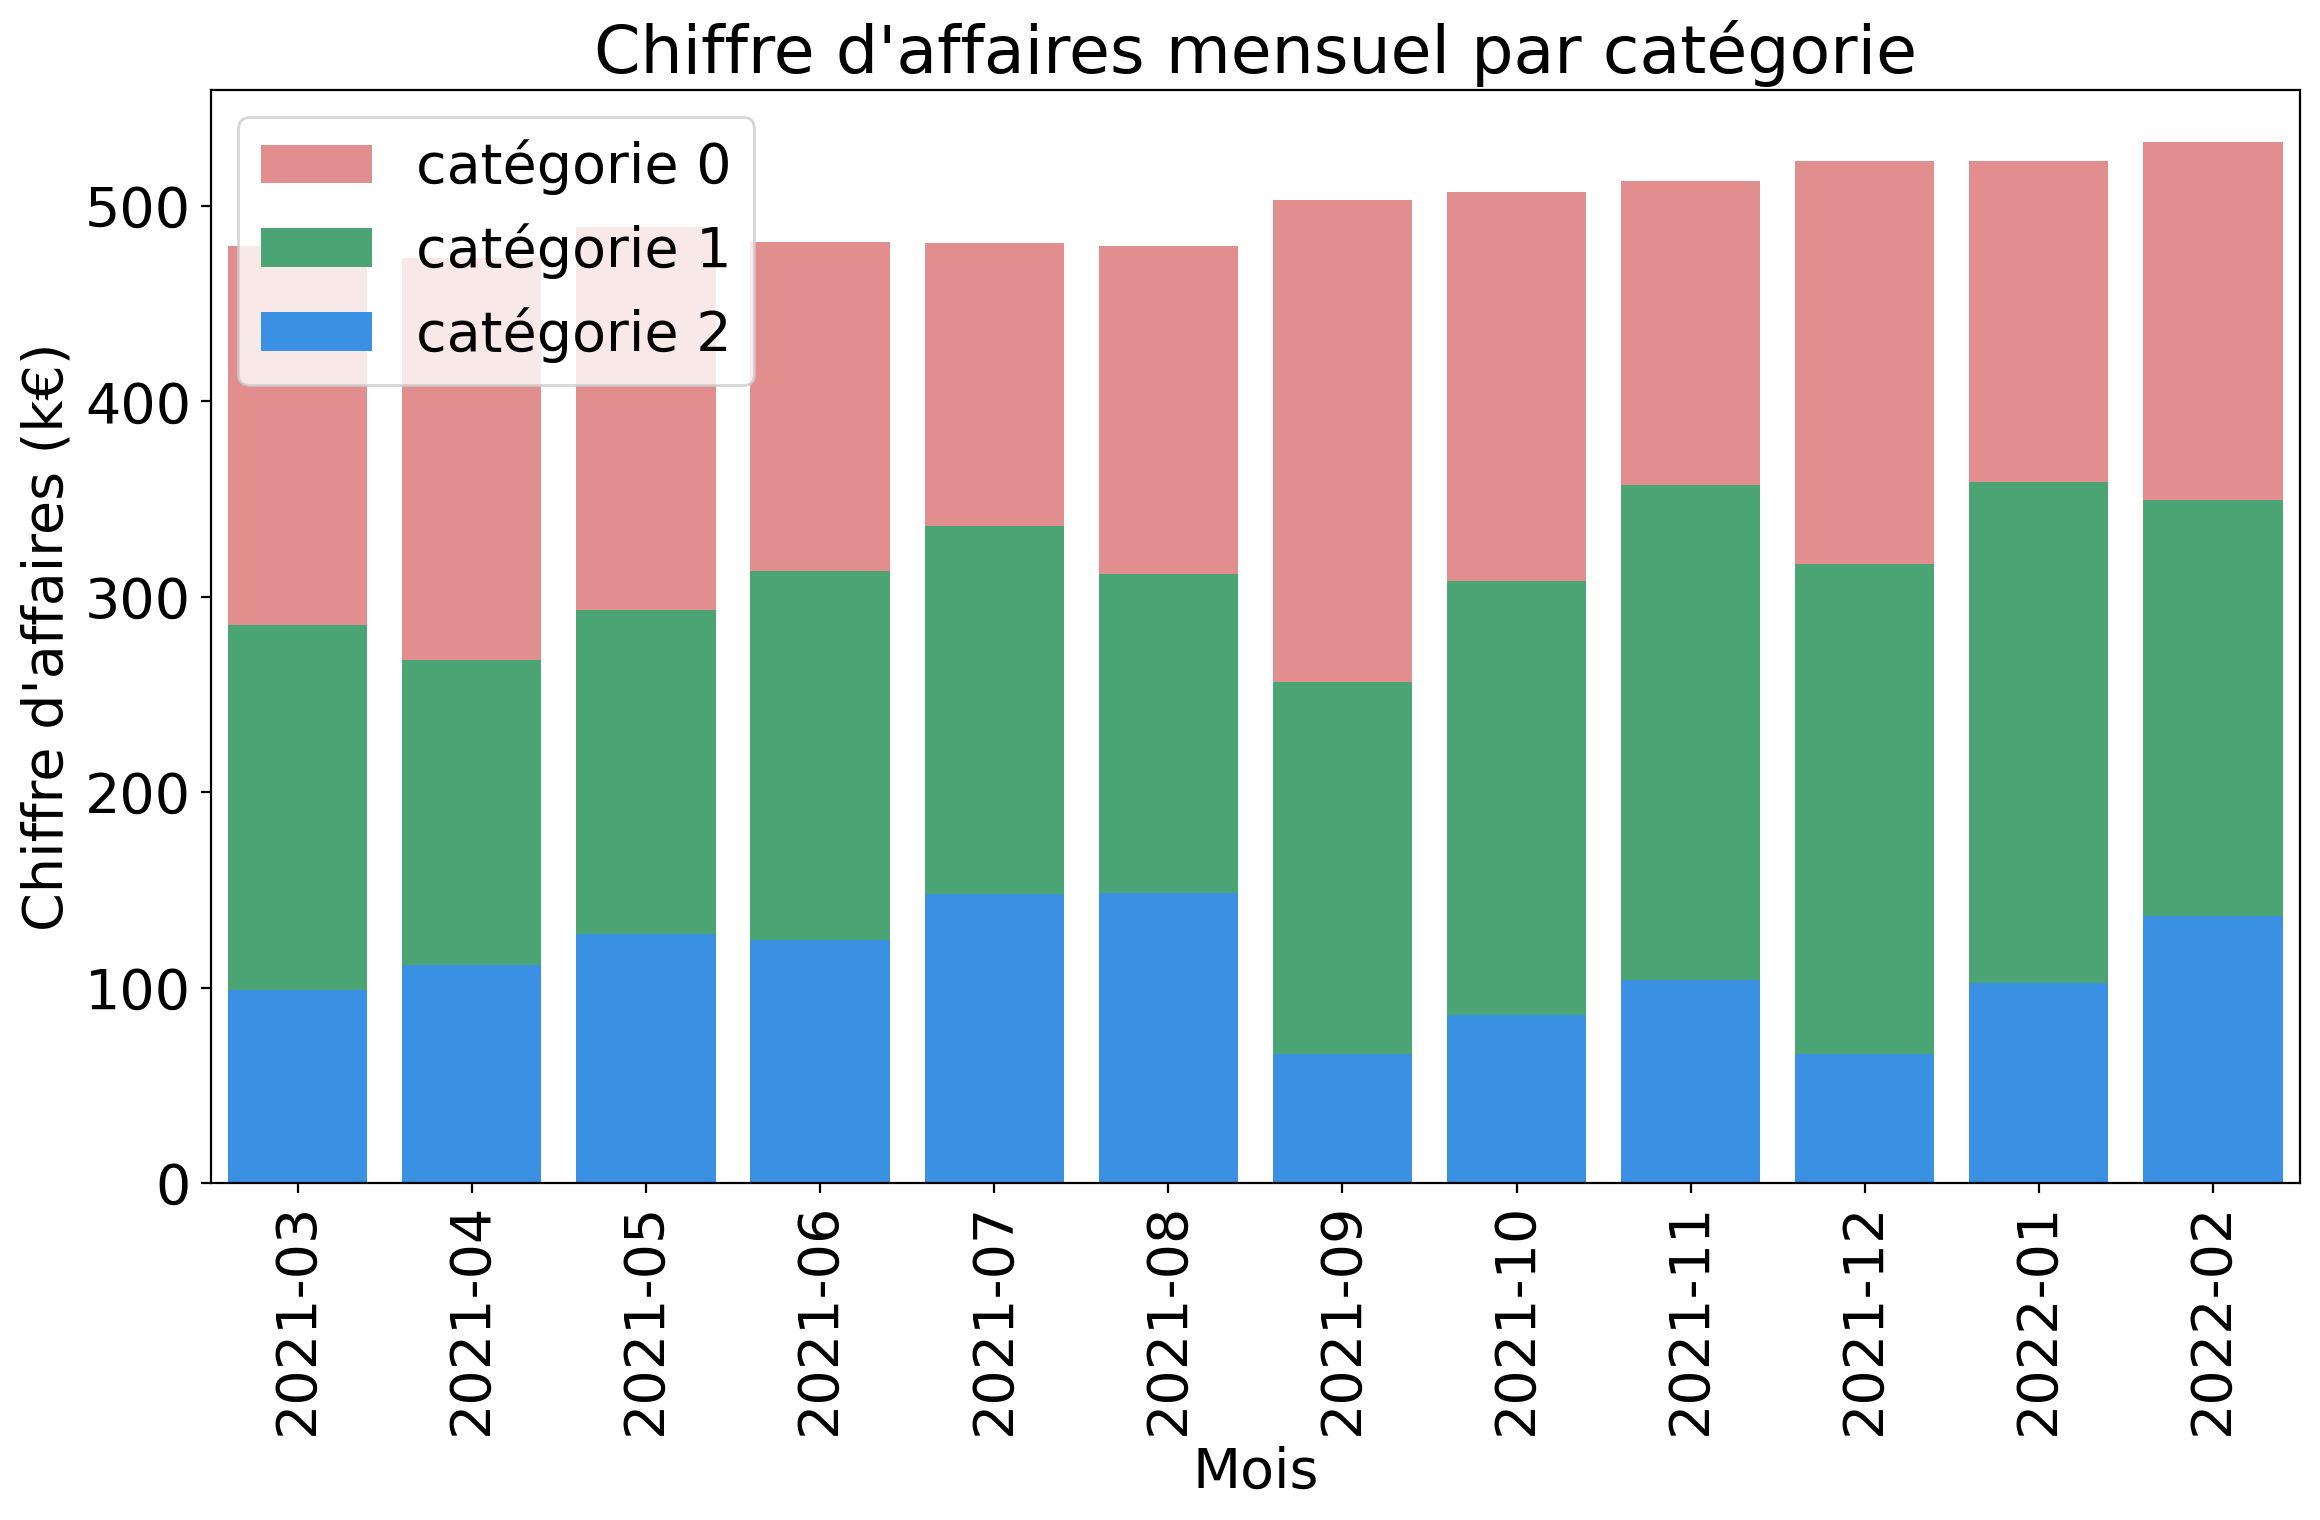

In [12]:
# sales bar chart

transactions_original_with_outliers = pd.concat([transactions_original, outliers])

# global turnover
global_month_sale = transactions_original_with_outliers[['price','categ']].groupby('categ').resample('M').sum()
global_month_sale = global_month_sale.reset_index()

# visual fix for categ 1 october sales : mean of September/November categ 1
global_month_sale.loc[19,'price'] = (global_month_sale.loc[18,'price'] + global_month_sale.loc[20,'price'])/2

# visual date fix
global_month_sale['date'] = global_month_sale['date'].astype('str')
global_month_sale['date'] = global_month_sale['date'].str[0:-3]

# visual turnover fix
global_month_sale['price'] /= 1000

# categories
c_0 = global_month_sale.copy()
c_0 = c_0.groupby('date').sum().reset_index()

c_1 = global_month_sale[(global_month_sale['categ'] != 'c_0')]
c_1 = c_1.groupby('date').sum().reset_index()


c_2 = global_month_sale[global_month_sale['categ'] == 'c_2']

# figure settings
plt.style.use('default')
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12,8), dpi=200)

#sns.set_color_codes('pastel')
sns.barplot(x='date', y='price', 
            data=c_0,
            label='catégorie 0',
            color='lightcoral')


sns.barplot(x='date', y='price', 
            data=c_1,
            label='catégorie 1',
            color='mediumseagreen')

sns.barplot(x='date', y='price', 
            data=c_2,
            label='catégorie 2',
            color='dodgerblue')

plt.title("Chiffre d'affaires mensuel par catégorie")
plt.ylabel("Chiffre d'affaires (k€)")
plt.xlabel("Mois")
plt.xticks(rotation=90)
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.savefig('./img/histo_timeseries_sales.png')
plt.show()

## Variations de la Récence (durée entre 2 achats) au cours du temps

In [13]:
# data array [timestamp, id_sale, id_customer]
df = np.array(transactions_original[['id_sale', 'id_customer']].reset_index())

# 1 timestamp = 1 id_customer
df = df[df[:, 1].argsort()]
df = df[np.unique(df[:, 1], return_index=True)[1]]
df = df[:, [0, 2]]

# sort by id_customer then by timestamp, order by DESC
multi_index = np.core.records.fromarrays([df[:,1],df[:,0]])
df = df[multi_index.argsort()][::-1]

# copy df then concatenate with shifted array
df = np.concatenate((df[:-1], df[1:]), axis=1)

# drop rows where id_customer(df) != id_customer(shifted_array)
df = df[df[:, 1]==df[:, 3]]
df = df[:,[0, 2, 3]]

# compute recency 
date = df[:, 0] - df[:,1]
df[:, 1] = np.array([date[row].days for row in np.arange(date.shape[0])])

Manipulation de la table recency : sauvegarde des résultats

In [14]:
df = pd.DataFrame(data=df, columns=['date','recency','id_customer'])
df = df.sort_values(by='date')
df = df.set_index('date')
df['recency'] = df['recency'].astype('int')

Recency mediane par client par mois : mediane à cause des données, et agg par client car le recency est liée au client.

In [15]:
temp = df.groupby('id_customer').resample('M').median().reset_index()
temp = temp.drop('id_customer', axis=1)
temp  = temp.sort_values(by='date')

Création du graphique

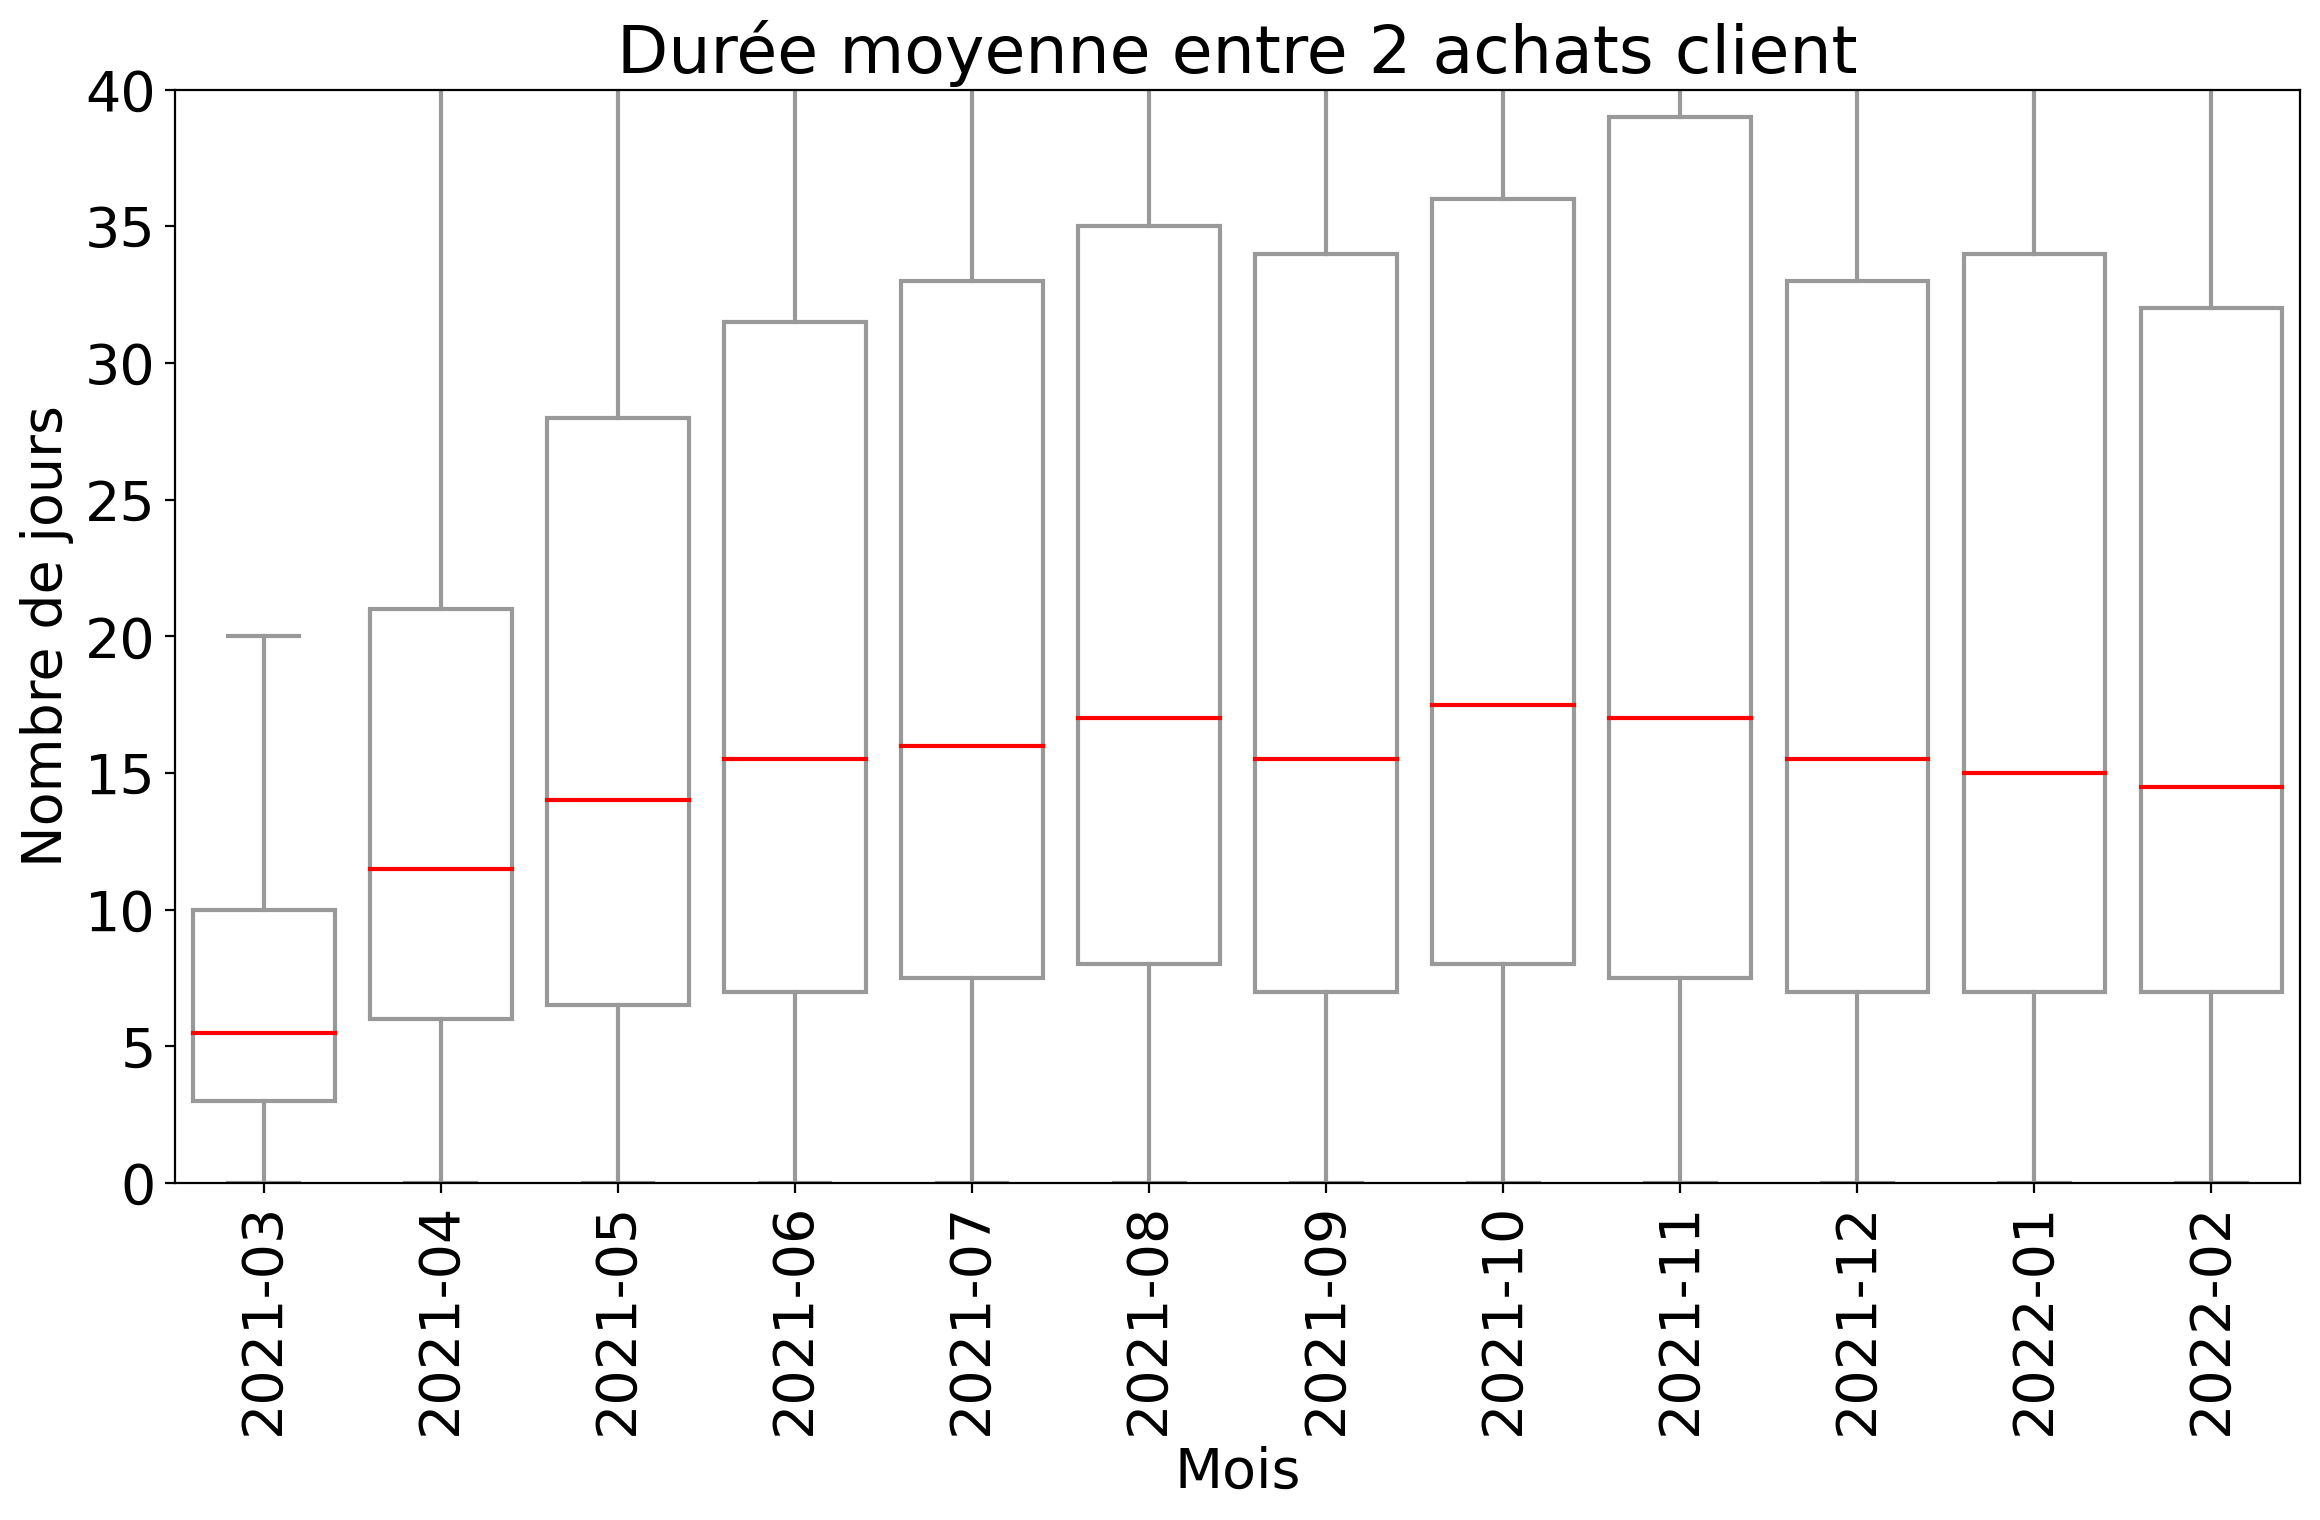

In [16]:
temp['date'] = temp['date'].astype('str')
temp['date'] = temp['date'].str[0:7]

# figure settings
plt.figure(figsize=(12,8), dpi=200)
plt.axis(ymax=40)

sns.boxplot(x='date', y='recency', 
            data=temp, 
            showfliers = False, 
            color='w',
            medianprops={'color':'red'})

plt.title('Durée moyenne entre 2 achats client')
plt.ylabel("Nombre de jours")
plt.xlabel("Mois")
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('./img/boxplot_timeseries_recency.png')
plt.show()

## Variations du panier moyen au cours du temps par catégorie avec écart type

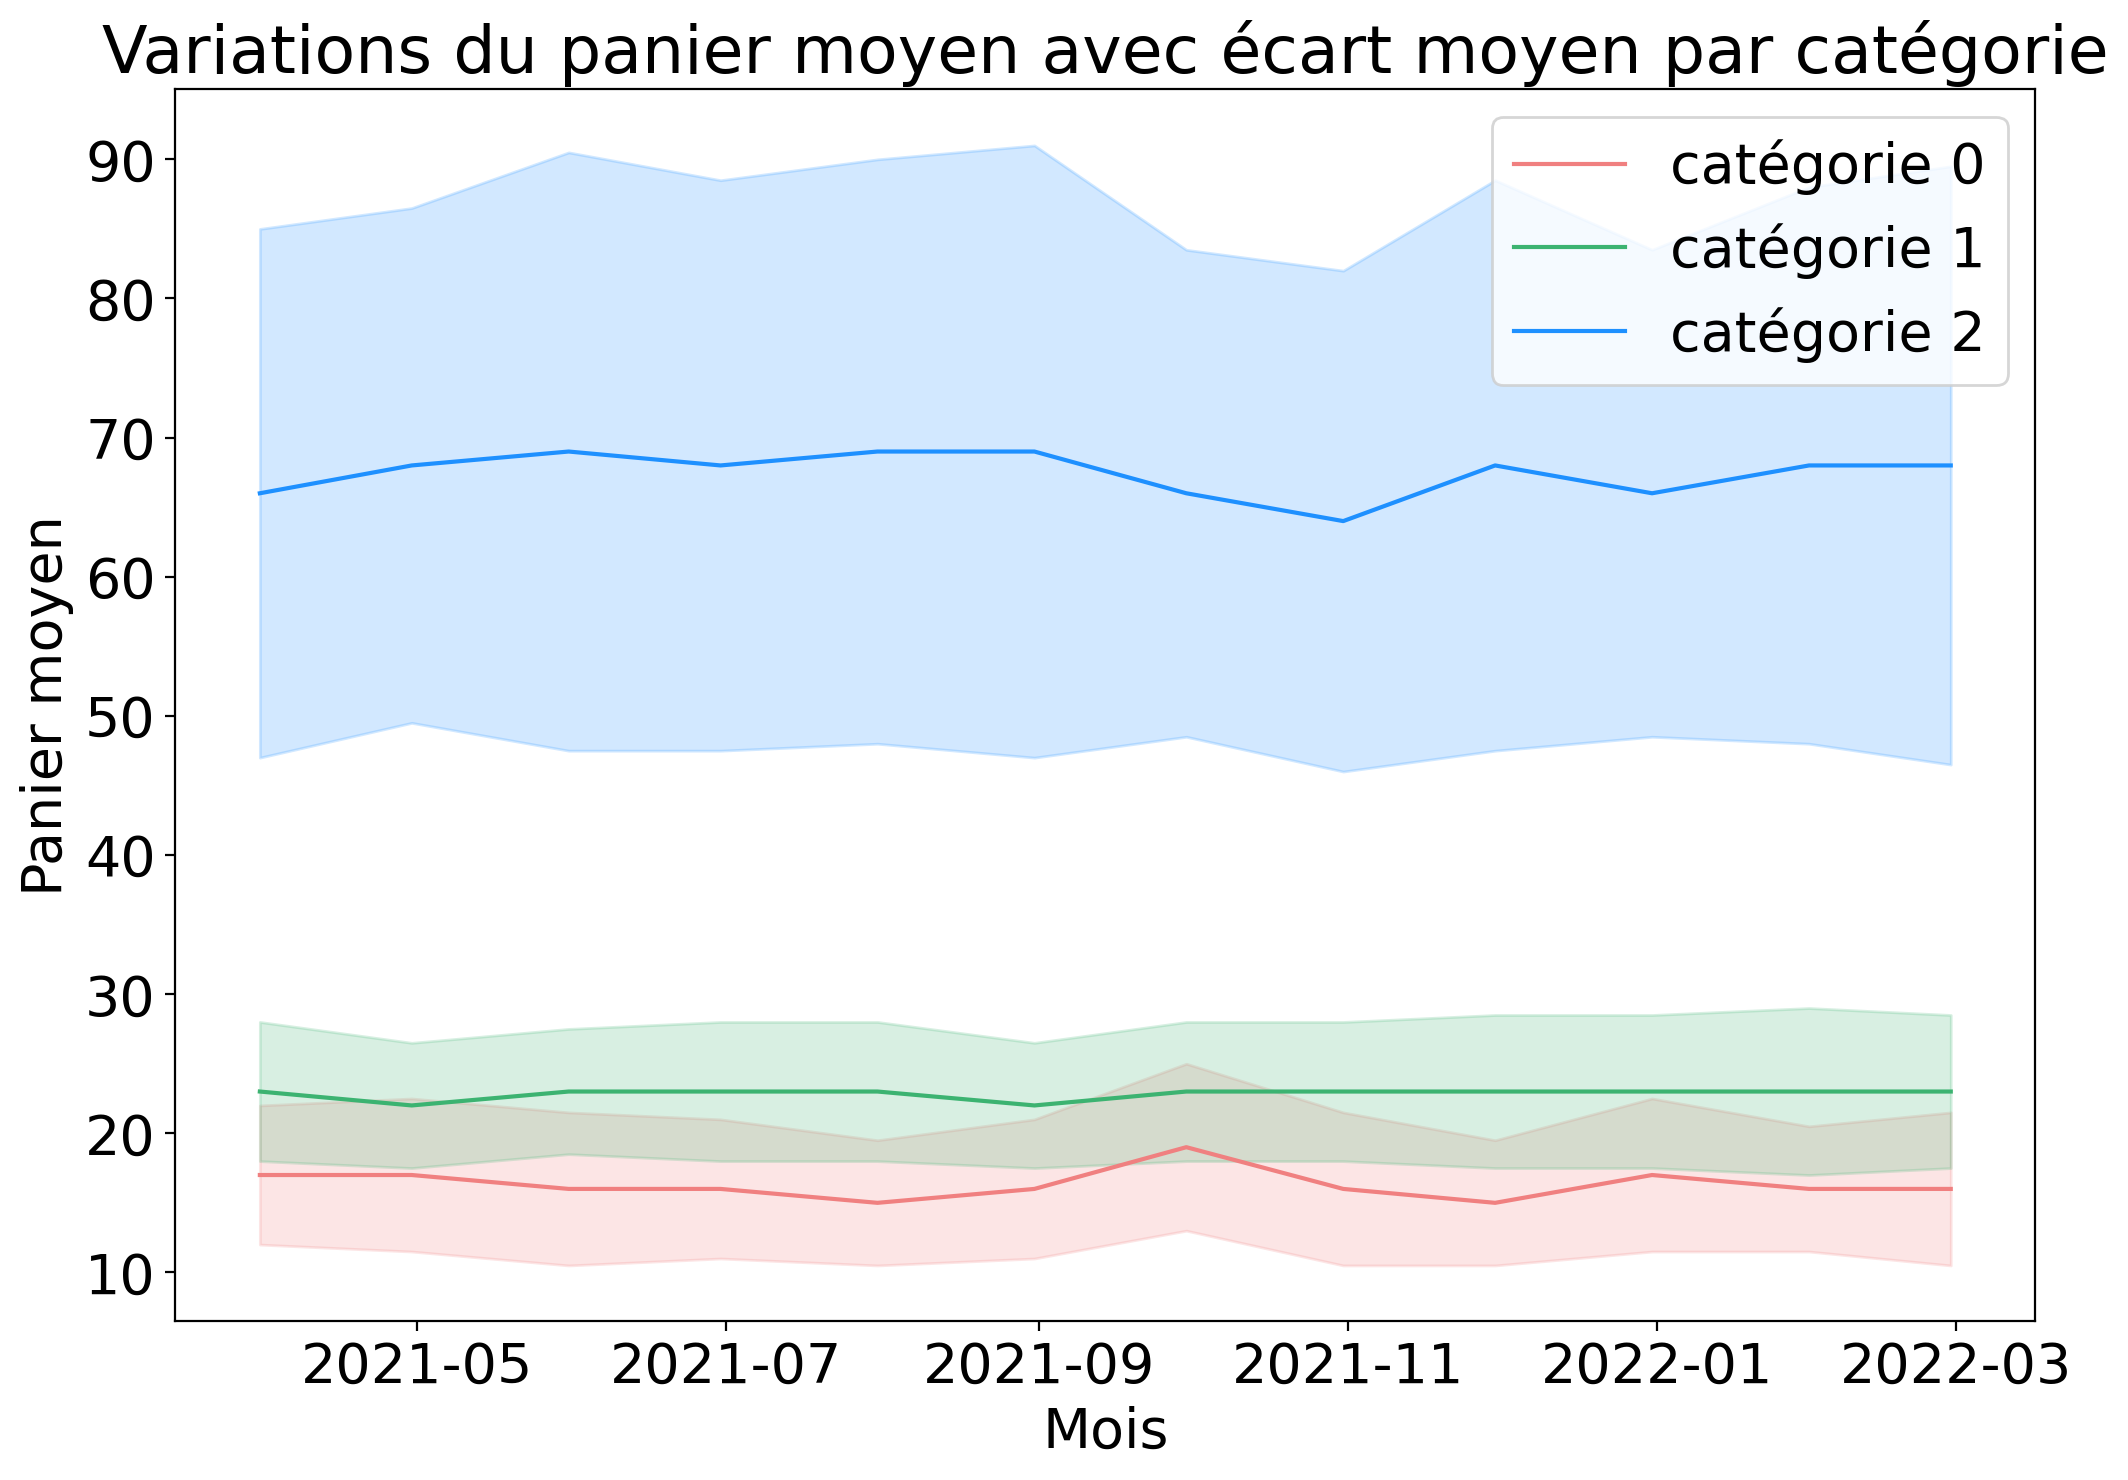

In [17]:
# create sales table : total + categ
sales_table = transactions_original[['id_sale','price','categ']].copy()
sales_table = p4.one_hot_matrix('categ', sales_table)
sales_table = sales_table.groupby(['id_sale', 'c_0', 'c_1', 'c_2']).sum().reset_index()
sales_table = sales_table.rename(columns={'price' : 'total'})

# to drop category sales quantity
sales_table = sales_table.drop_duplicates()

# to gather data : temp sales table : 1 sale = 1 DateTimeIndex
temp_table = transactions_original[['id_sale']].copy()
temp_table = temp_table.drop_duplicates().reset_index()

# to merge tables
sales_table = sales_table.merge(temp_table, left_on='id_sale', right_on='id_sale')
sales_table = sales_table.set_index('date')

# categ_0 data
categ_0 = sales_table[sales_table['c_0'] == True]
categ_0 = categ_0.resample('M').agg({'total' : ['median', 'mad']})
categ_0 = categ_0.round()

# categ_1 data
categ_1 = sales_table[sales_table['c_1'] == True]
categ_1 = categ_1.resample('M').agg({'total' : ['median', 'mad']})
categ_1 = categ_1.round()

#categ 2 data
categ_2 = sales_table[sales_table['c_2'] == True]
categ_2 = categ_2.resample('M').agg({'total' : ['median', 'mad']})
categ_2 = categ_2.round()

# figure settings
plt.style.use('default')
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12,8), dpi=200)

sns.set_color_codes('pastel')
sns.lineplot(x=categ_0.index, y=('total','median'), 
            data=categ_0,
            label='catégorie 0',
            color='lightcoral')


plt.fill_between(categ_0.index, 
                 categ_0[('total','median')] + categ_0[('total','mad')]/2, 
                 categ_0[('total','median')] - categ_0[('total','mad')]/2,
                 color='lightcoral',
                 alpha=0.2)


sns.set_color_codes('muted')
sns.lineplot(x=categ_1.index, y=('total','median'), 
            data=categ_1,
            label='catégorie 1',
            color='mediumseagreen')


plt.fill_between(categ_1.index, 
                 categ_1[('total','median')] + categ_1[('total','mad')]/2, 
                 categ_1[('total','median')] - categ_1[('total','mad')]/2,
                 color='mediumseagreen',
                 alpha=0.2)

sns.set_color_codes('bright')
sns.lineplot(x=categ_2.index, y=('total','median'), 
            data=categ_2,
            label='catégorie 2',
            color='dodgerblue')

plt.fill_between(categ_2.index, 
                 categ_2[('total','median')] + categ_2[('total','mad')]/2, 
                 categ_2[('total','median')] - categ_2[('total','mad')]/2,
                 color='dodgerblue',
                 alpha=0.2)

plt.title('Variations du panier moyen avec écart moyen par catégorie')
plt.ylabel("Panier moyen")
plt.xlabel("Mois")
plt.legend()
plt.savefig('./img/line_plot_timeseries_avg_basket_sales.png')
plt.show()